In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics


import dask
#dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
#from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# client = Client()
# client

In [3]:
E = ed.EsioData.load()
# Directories
runType='forecast'


In [4]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['IFD']}
# Some models are terrible/have serious issues, so don't include in MME
MME_NO = ['hcmr']

In [5]:
# Target time range
valid_start = np.datetime64('2019-06-01')
valid_end = np.datetime64('2019-09-30')

In [6]:
# SIO Report Year_Month
cyear = '2019'
#cmonth = 'June'
cmonth = 'July'
cmonth = 'August'

month_cal=dict((v,k) for k,v in enumerate(calendar.month_abbr))
itstr = date_str = pd.to_datetime(datetime.datetime(int(cyear), month_cal[cmonth[0:3]], 1)).strftime('%Y-%m-%d')
itstr
r_yr_mon = cyear+'_'+cmonth
def_icefree = pd.to_datetime('2019-08-01').timetuple().tm_yday # doy that icefee even icefree at start
    # make it june 1 does not matter what year

print(itstr)
print(r_yr_mon)

2019-08-01
2019_August


In [7]:
# Models that create an Ensemble using different init days
it_target_size = {'usnavysipn':10, 'ukmetofficesipn':21} # Define the number of past days to use TODO: assumes daily inits

In [8]:
# Define custom mod names, okay if not used
# https://docs.google.com/document/d/1eztVwPllCKDYOXbZ4nBt3j-3aK3YeOfAf6TPSb-86fQ/edit 
custom_names = {'usnavysipn':'Navy ESPC','gfdlsipn':'NOAA GFDL','noaasipn':'NCEP CPC','uclsipn':'UCL',
                'ukmetofficesipn':'Met. Office','ecmwfsipn':'ECMWF-c3s',
                'gmao':'NASA GMAO','seansipn':'NSIDC,\nCU Boulder', 'piomas':'UW APL',
                'awispin':'AWI\nConsortium','szapirosipn':'MPAS-CESM',
                'nmisipn':'Norwegian\nMet. Inst.','fgoalssipn':'IAP LASG',
                'nicosipn':'Sun','Xiaojun':'Lamont','modcansipns_4':'Modified\nCanSIPS'}


In [9]:
# Define models to plot and not to plot
No_No_models = ['MME_NEW','piomas','MME','modcansipns_3','modcansipns_4','ecmwfsipn','usnavygofs',
                   'szapirosipn','noaasipn_ext','rasmesrl','uclsipn','noaasipn','yopp','nicosipn'] #, 'usnavysipn']
non_SIPN_Report_models  = ['ecmwf','ukmo','kma','ncep','usnavyncep','metreofr','dampedAnomalyTrend'] # Models like s2s
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in No_No_models) ] # remove some models
models_2_plot = [x for x in models_2_plot if np.any(x not in non_SIPN_Report_models) ] # remove some more models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models


models_2_plot

['gfdlsipn', 'ukmetofficesipn', 'usnavysipn', 'awispin', 'fgoalssipn']

In [10]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [11]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

### Load in User submited IFD data

In [12]:
user_ifd = [] # Dictionary to store user submitted (regridded) SIP data
mon_2_int = {v: k for k,v in enumerate(calendar.month_name)}

### cansips (Mod CanSIPS)

273.0
212.0
275.0
Create weight file: nearest_s2d_18x128_304x448.nc
Remove file nearest_s2d_18x128_304x448.nc


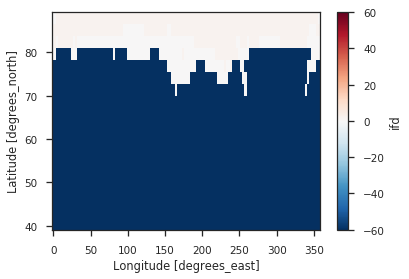

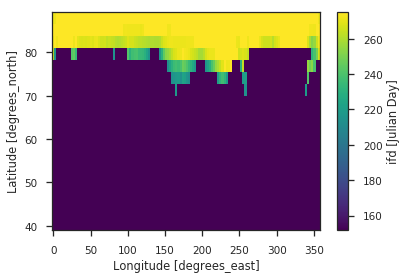

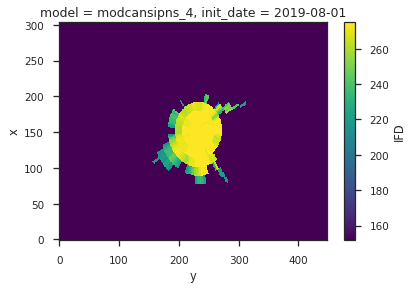

In [13]:
cmod = 'modcansipns_4'

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/upload/escersipn/forecast/Modified_CanSIPS_fields_postprocessed/June-init/ifd_bc_i2019m06_Mod_CanSIPS.nc'
elif r_yr_mon=='2019_July':
    sip_f=None
elif r_yr_mon=='2019_August':
    sip_f='/home/disk/sipn/upload/escersipn/forecast/Modified_CanSIPS_fields_postprocessed/August-init/ifd_bc_i2019m08_Mod_CanSIPS.nc'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")   

if sip_f:
    ds_user = xr.open_dataset(sip_f, drop_variables='time')
    ds_user.rename({'longitude':'lon','latitude':'lat'}, inplace=True);
    ds_user.set_coords(['lat','lon'], inplace=True)
    da_in = ds_user.ifd
    print(da_in.max().values)
    print(da_in.min().values)

    da_diff = da_in
    # Set never melts to first valeus (to be consistent with how sipn does it)
    # da_in = da_in.where(da_in<da_in.max().values, other=da_in.min().values)
    # Set pernial to 275
    da_in = da_in.where(da_in<(da_in.max().values), other=275)
    print(da_in.max().values)

    # Set pixels that are ice free at init, to -9999
    da_in = da_in.where(da_in!=da_in.min().values, other=152) #pd.to_datetime('2018-06-01').timetuple().tm_yday)

    da_diff=da_in - da_diff
    plt.figure()
    da_diff.plot()

    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 

    da_save = da_out

    da_out.name = 'IFD'

    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    da_out = da_out.expand_dims('model')
    # da_out.coords['init_date'] = xr.DataArray(np.array([np.datetime64(datetime.date(int(cyear), 1, 1) + datetime.timedelta(da_in.min().values - 1))]), 
    #                                           dims='model', coords={'model':da_out.model})
    da_out.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                              dims='model', coords={'model':da_out.model})

    da_out = da_out.rename({'nj':'x', 'ni':'y'})
    user_ifd.append(da_out)

    plt.figure()
    da_in.plot()
    plt.figure()
    da_out.plot()

In [14]:
user_ifd

[<xarray.DataArray 'IFD' (model: 1, x: 304, y: 448)>
 array([[[152., 152., ..., 152., 152.],
         [152., 152., ..., 152., 152.],
         ...,
         [152., 152., ..., 152., 152.],
         [152., 152., ..., 152., 152.]]])
 Coordinates:
     lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
     lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
   * model      (model) <U13 'modcansipns_4'
     init_date  (model) datetime64[ns] 2019-08-01
 Dimensions without coordinates: x, y
 Attributes:
     regrid_method:  nearest_s2d]

### GMAO

In [15]:
cmod = 'gmao'

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/gmao/nasa_gmao_Sep2019_Junedata.nc4'
elif r_yr_mon=='2019_July':
    sip_f = '/home/disk/sipn/nicway/data/model/gmao/nasa_gmao_Sep2019_Junedata.nc4'
elif r_yr_mon=='2019_August':
    sip_f=None
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    landmask = ds_user.IFD.notnull()
    
    # Mask
    ds_user = ds_user.set_coords(['LAT','LON'])

    da_in = ds_user.rename({'LON':'lon','LAT':'lat'}).IFD
    
    # Set never melts to first valeus (to be consistent with how sipn does it)
    da_in = da_in.where(da_in<da_in.max().values, other=275)
    
    da_in = da_in.where(landmask)
    

    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 

    da_out.name = 'IFD'
    da_out = da_out.rename({'nj':'x', 'ni':'y'})

    da_in.plot()
    plt.figure()
    da_out.plot()

    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    da_out = da_out.expand_dims('model')
    da_out.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                          dims='model', coords={'model':da_out.model})
    user_ifd.append(da_out)
    

## FGOALS

In [17]:
# I moved this to a Regrid_FGOALS_Forecast.ipynb notebook so July 2019 and foreward
# should run that first and then include fgoals as a "regular" model
# should work for June too but haven't tried it
cmod = 'fgoalssipn'

# daily freq of sic (0,1) 40 ens member so compute Sep SIC and compute binary ice presence = SIP then avg across ens
Update_FGOALS = False  # only do when needed since very slow
Update_FGOALS = True  # only do when needed since very slow
rereadit = False  # redoing takes forever but probably but probably always need to Update but not reread since
  # writing IFD to file seems to lose its name, not sure why

if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/F1.2-20190601-*.cice.h1.2019-09*.nc'
elif r_yr_mon=='2019_July':
    sip_f=None
    # must fix the slice in itime below for other months
elif r_yr_mon=='2019_August':
    sip_f=None
    # must fix the slice in itime below for other months
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    if Update_FGOALS:
        if rereadit:
            da_all = []
            for ens in np.arange(1,41,1):
                # read in daily data for each ens and avg to monthly sic and append to one big data array
                fens = '/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/F1.2-20190601-'+str(ens).zfill(2)+'.cice.h1.2019-0[6-9]*.nc'
                ds_model = xr.open_mfdataset(fens, 
                                chunks={'time': 1, 'nj': 112, 'ni': 320}, 
                                                 concat_dim='time', autoclose=True, parallel=True)
                da=ds_model.aice_d
                da.coords['ensemble'] = ens
                da = da.expand_dims('ensemble')
                da_all.append(da)
                print(ens)

            da_all = xr.concat(da_all, dim='ensemble')
            da_all = da_all.mean(dim='ensemble')
            da_all.name = 'sic'
            da_all.coords['lon'] = da_all.TLON
            da_all.coords['lat'] = da_all.TLAT
            da_all = da_all.drop(['TLAT','TLON'])
            da_all = da_all/100 # percent to fraction
            da_all = da_all.isel(time=slice(0,121)) # time is off not sure why

            da_all.to_netcdf('/home/disk/sipn/nicway/data/model/fgoalssipn/metric/'+cyear+'_'+cmonth+'SIC_ensmean_daily.nc')
        else:
            da_all=xr.open_mfdataset('/home/disk/sipn/nicway/data/model/fgoalssipn/metric/'+cyear+'_'+cmonth+'SIC_ensmean_daily.nc')
            da_all=da_all.sic

        print(da_all)

        regridder = xe.Regridder(da_all, obs_grid, method, periodic=False)
        # Regrid 
        da_out = regridder(da_all)
        # Remove weight file
        regridder.clean_weight_file() 
        da_out.name = 'sic'
        
        da = xr.DataArray(da_out.values,dims=['fore_time','x','y'])
        da=da.expand_dims('init_time')
        da.name = 'sic'
        da.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]),dims='init_time')
        vt_vec = np.arange(datetime.datetime(2019,6,2),datetime.datetime(2019,10,1),datetime.timedelta(days=1)).astype('datetime64[ns]')
        da.coords['valid_time'] = xr.DataArray(vt_vec,dims='fore_time')
        da.coords['lon'] = xr.DataArray(da_save.lon.values,dims=['x','y'])  # these are the lat and lon from can sips
        da.coords['lat'] = xr.DataArray(da_save.lat.values,dims=['x','y'])

        ds_model = da
        da = None
        da_out = None
        ds_model.load()

        print('what is the time dim?')
        print(ds_model)
        # Calculate IFD
        print("    Calculating IFD")

        DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
        ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                    Nday=10, default_ice_free=def_icefree)

        ds_ifd.name = 'IFD'
        ds_ifd=ds_ifd.drop(['valid_time'])

        ds_ifd.coords['model'] = cmod
        ds_ifd = ds_ifd.expand_dims('model')
        ds_ifd.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                                dims='model', coords={'model':ds_ifd.model})

        ds_ifd.to_netcdf('/home/disk/sipn/nicway/data/model/fgoalssipn/metric/'+cyear+'_'+cmonth+'IFD.nc')
        
        ds_model = None

    else:
        ds_ifd=xr.open_mfdataset('/home/disk/sipn/nicway/data/model/fgoalssipn/metric/'+cyear+'_'+cmonth+'IFD.nc')

        
    ds_ifd.plot()
    plt.figure()
    user_ifd.append(ds_ifd)

## Nice Sun

vt_vec is  61
    Calculating IFD
213 213
<xarray.DataArray 'sic' (fore_time: 61, x: 304, y: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    valid_time  (fore_time) datetime64[ns] 2019-08-01 2019-08-02 ... 2019-09-30
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
Dimensions wit

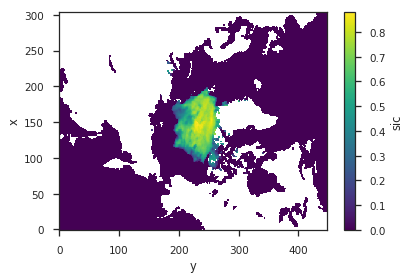

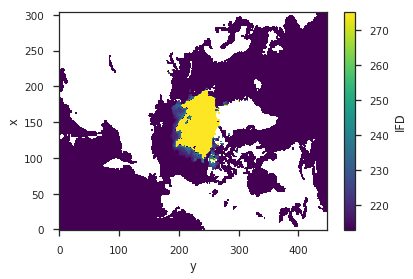

<Figure size 432x288 with 0 Axes>

In [18]:
cmod = 'nicosipn'
NMAX = 122
# Nicos files have time variable = 1 to 122 and always start on June 1 so must chop off 
if r_yr_mon=='2019_June':
    sip_f = '/home/disk/sipn/upload/nicosipn/forecast/2019_06/NicoSun_2019_002_concentration.nc'
    NMIN=1
elif r_yr_mon=='2019_July':
    sip_f = '/home/disk/sipn/upload/nicosipn/forecast/2019_07/NicoSun_2019_002_concentration.nc'
    NMIN=31
elif r_yr_mon=='2019_August':
    sip_f = '/home/disk/sipn/upload/nicosipn/forecast/2019_08/NicoSun_2019_002_concentration.nc'
    # must fix the slice in itime below for other months
    NMIN=61
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    ds_user = ds_user.isel(time=range(NMIN,NMAX))
    theland = ds_user.sftof  # nico land mask        
    ds_user = ds_user.siconc
    ds_user = ds_user.where(theland<50, other=np.nan)
    
    da = xr.DataArray(ds_user.values/100,dims=['fore_time','y','x'])
    da=da.transpose('fore_time','x','y')    
    #da=da.expand_dims('init_time')
    da.name = 'sic'    
    #da.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]),dims='init_time')
    
    if r_yr_mon=='2019_June':
        vt_vec = np.arange(datetime.datetime(2019,6,1),datetime.datetime(2019,10,1),datetime.timedelta(days=1)).astype('datetime64[ns]')
    elif r_yr_mon=='2019_July':
        vt_vec = np.arange(datetime.datetime(2019,7,1),datetime.datetime(2019,10,1),datetime.timedelta(days=1)).astype('datetime64[ns]')
    elif r_yr_mon=='2019_August':
        vt_vec = np.arange(datetime.datetime(2019,8,1),datetime.datetime(2019,10,1),datetime.timedelta(days=1)).astype('datetime64[ns]')

    print('vt_vec is ',len(vt_vec))
    da.coords['valid_time'] = xr.DataArray(vt_vec,dims='fore_time')
    da.coords['lon'] = xr.DataArray(obs_grid.lon.values,dims=['x','y'])  # these are the lat and lon from can sips
    da.coords['lat'] = xr.DataArray(obs_grid.lat.values,dims=['x','y'])

    ds_model = da
    da = None
    ds_model.load()
    
    # Calculate IFD
    print("    Calculating IFD")
#             if cmod=='szapirosipn':
#                 xr.exit()

    DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
    print(DOY_first_vt[0], def_icefree)
    print(ds_model)
    ds_model.min(dim='fore_time').plot()
    plt.figure()
    
    #perenial_ice_mask = (ds_model.min(dim='fore_time') >= sic_threshold)
    

    ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                Nday=10, default_ice_free=def_icefree)

#    ds_ifd = calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=213, time_dim='fore_time', 
#                                Nday=10, default_ice_free=def_icefree)

    ds_ifd.name = 'IFD'
    ds_ifd=ds_ifd.drop(['valid_time'])
    ds_ifd.plot()
    plt.figure()
    
    ds_ifd.coords['model'] = cmod
    ds_ifd = ds_ifd.expand_dims('model')
    ds_ifd.coords['init_date'] = xr.DataArray(np.array([np.datetime64(itstr)]), 
                                            dims='model', coords={'model':ds_ifd.model})
    user_ifd.append(ds_ifd)
    ds_model = None
    ds_ifd = None

In [19]:
# Concat them together by model
usr_IFD = xr.concat(user_ifd, dim='model')
#usr_IFD = usr_IFD.rename({'nj':'x', 'ni':'y'})
usr_IFD.name = 'IFD'
usr_IFD

<xarray.DataArray 'IFD' (model: 2, x: 304, y: 448)>
array([[[152., 152., ..., 152., 152.],
        [152., 152., ..., 152., 152.],
        ...,
        [152., 152., ..., 152., 152.],
        [152., 152., ..., 152., 152.]],

       [[213., 213., ...,  nan,  nan],
        [213., 213., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 213., 213.],
        [ nan,  nan, ..., 213., 213.]]])
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * model      (model) object 'modcansipns_4' 'nicosipn'
    init_date  (model) datetime64[ns] 2019-08-01 2019-08-01
Dimensions without coordinates: x, y

In [23]:
# Define the last init day as the 11th of the current month's report (i.e. June would be the 13th of June)
if cmonth=='August':
    last_init_day = np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth],14))
else:
    last_init_day = np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth],13))

# Define the earliest init day as 1 year before last_init_day ( some models init on 1st of month (i.e. UCL))
first_init_day = np.datetime64(datetime.datetime(int(cyear),1,1))-np.timedelta64(2,'D')    # last_init_day-np.timedelta64(365,'D')
print("Looking for init times between",first_init_day,"and",last_init_day)

Looking for init times between 2018-12-30T00:00:00.000000 and 2019-08-14T00:00:00.000000




----------------  gfdlsipn
NEAR START, ds_model is  <xarray.Dataset>
Dimensions:    (ensemble: 12, fore_time: 365, init_time: 8, x: 304, y: 448)
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * fore_time  (fore_time) timedelta64[ns] 0 days 1 days ... 363 days 364 days
  * init_time  (init_time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-08-01
Dimensions without coordinates: x, y
Data variables:
    sic        (ensemble, init_time, fore_time, x, y) float64 dask.array<shape=(12, 8, 365, 304, 448), chunksize=(12, 1, 365, 304, 448)>
    hi         (ensemble, init_time, fore_time, x, y) float64 dask.array<shape=(12, 8, 365, 304, 448), chunksize=(12, 1, 365, 304, 448)>
    Init time used is 2019-08-01T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (init_time: 1, fore_time: 61, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * fore_time   (fore_time) timedelta64[ns] 0 days 1 days ... 59 days 60 days
  * init_time   (init_time) datetime64[ns] 2019-08-01
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-01 ... 2019-09-30
Dimensions without coordinates: x, y
    Calculating IFD
DOY_first_vt  [213]
******ds_model looks like ****** <xarray.DataArray (init_time: 1, fore_time: 61, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (init_time: 1, fore_time: 60, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 1 days 2 days ... 59 days 60 days
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * init_time   (init_time) datetime64[ns] 2019-08-01
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-02 ... 2019-09-30
Dimensions without coordinates: x, y
    Calculating IFD
DOY_first_vt  [214]
******ds_model looks like ****** <xarray.DataArray (init_time: 1, fore_time: 60, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 1 days 2 days .

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (init_time: 1, fore_time: 163, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 0 days 12:00:00 ... 81 days 12:00:00
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * init_time   (init_time) datetime64[ns] 2019-07-10T12:00:00
    valid_time  (init_time, fore_time) datetime64[ns] 2019-07-11 ... 2019-09-30
Dimensions without coordinates: x, y
    Calculating IFD
DOY_first_vt  [192]
******ds_model looks like ****** <xarray.DataArray (init_time: 1, fore_time: 163, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 0

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (init_time: 1, fore_time: 50, x: 304, y: 448)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 0 days 1 days ... 48 days 49 days
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * init_time   (init_time) datetime64[ns] 2019-08-12
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-12 ... 2019-09-30
Dimensions without coordinates: x, y
    Calculating IFD
DOY_first_vt  [224]
******ds_model looks like ****** <xarray.DataArray (init_time: 1, fore_time: 50, x: 304, y: 448)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * fore_time   (fore_time) t

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (init_time: 1, fore_time: 47, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * fore_time   (fore_time) timedelta64[ns] 1 days 2 days ... 46 days 47 days
  * init_time   (init_time) datetime64[ns] 2019-08-14
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-15 ... 2019-09-30
Dimensions without coordinates: x, y
    Calculating IFD
DOY_first_vt  [227]
******ds_model looks like ****** <xarray.DataArray (init_time: 1, fore_time: 47, x: 304, y: 448)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... 

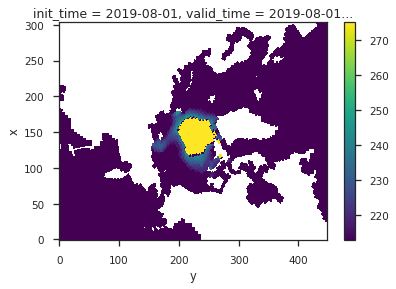

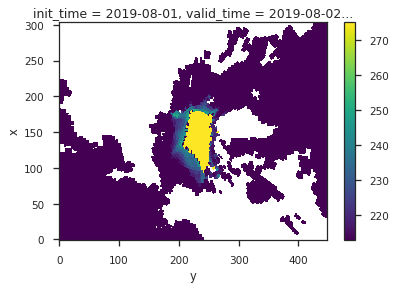

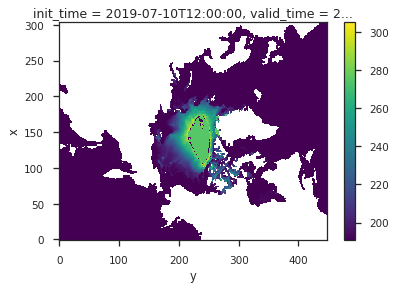

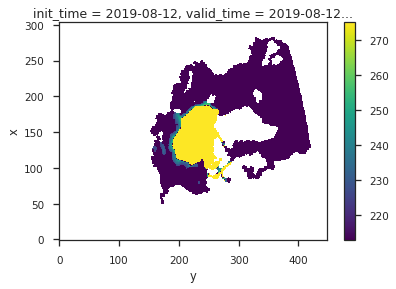

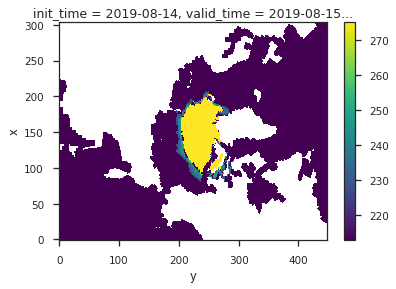

<Figure size 432x288 with 0 Axes>

In [24]:
for cvar in variables:
    
    # Define fig dir and make if doesn't exist
    fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
       
    # Loop through variable of interest + any metrics (i.e. SIP) based on that
    for metric in metrics_all[cvar]:

        MME_list = []      
    
        # For each model
        for (i, cmod) in enumerate(models_2_plot): # ['nicosipn']
        #for (i, cmod) in enumerate(['usnavysipn']): # ['nicosipn']
            print('\n\n---------------- ',cmod)

                        # Load in Model data for just this year
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], 
                                          '*'+cyear+'*.nc') 

            if (cmod=='fgoalssipn') and (cmonth == 'July'):
                model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], 
                                          '*20190709_Stereo.nc') 
                print('WARNING NEED TO UPDATE FGOALS BY HAND BECAUSE FTIMES VARY IN NUMBER GRR')
            elif (cmod=='fgoalssipn') and (cmonth == 'August'):
                model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], 
                                          '*2019081[2-4]*_Stereo.nc') 
                print('WARNING NEED TO UPDATE FGOALS BY HAND BECAUSE FTIMES VARY IN NUMBER GRR')
                print(model_forecast)

                
            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model
            ds_model = xr.open_mfdataset(model_forecast, 
                        chunks={'init_time': 1, 'nj': 304, 'ni': 448}, 
                                         concat_dim='init_time', autoclose=True, parallel=True)
            ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
            ds_model=ds_model.sortby(ds_model.init_time)
            print('NEAR START, ds_model is ',ds_model)

            # Restrictions for calculating IFD
            
            # 1) Must be Daily or less
            c_dt = (ds_model.fore_time[1]-ds_model.fore_time[0]).values.astype('timedelta64[D]').astype('int')
            if c_dt > 1:
                print("    fore_time timestep greater than 1 day, skipping.")
                continue
            
            # Select var of interest (if available)
            if cvar in ds_model.variables:
                ds_model = ds_model[cvar]
            else:
                print('    cvar not found.')
                continue
                  
            # Use lagged ensemble
            if cmod in list(it_target_size.keys()): # Uses a lagged ensemble... so grab all inits and make them ensembles
                
                # NESM (Joe) wants us to use the past months inits (June for July report)
                if cmod == 'usnavysipn':
                    # Replace last_init_day inline below (note the "-1" meaning last month)
                    ds_model = ds_model.sel(init_time=slice(first_init_day,  np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth] - 1, 11))  )) # First get all time between start and stop (up to and including the 10th)
                else:
                    ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                    
                print("    Init times used are",ds_model.init_time[-1*it_target_size[cmod]:].values)    
                
                ds_model = ds_model.sel(init_time=ds_model.init_time[-1*it_target_size[cmod]:]) # Get nearest date to 10th
                avg_init_time = ds_model.init_time.astype('int').max().astype('datetime64[ns]')
                ds_model = ds_model.stack(hybrid_ensemble=('ensemble', 'init_time')).reset_index('hybrid_ensemble')
                ds_model.coords['hybrid_ensemble'] = np.arange(1,ds_model.hybrid_ensemble.size+1,1)
                ds_model = ds_model.drop(['ensemble','init_time'])
                ds_model.coords['init_time'] = avg_init_time
                ds_model = ds_model.rename({'hybrid_ensemble':'ensemble'})
                print(ds_model)

            # Normal Ensemble
            else:
                if cmod=='awispin':
                    print('SELECTING LAST TIME')
                    print(ds_model.init_time.values)
                    ds_model = ds_model.isel(init_time=2) # Get nearest date to 10th
                else:
                    # Find init time closest and earlier to the 10th of the month
                    ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                    if ds_model.init_time.size==0:
                        print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                        continue
                    ds_model = ds_model.sel(init_time=last_init_day, method='nearest') # Get nearest date to 10th
                
            print("    Init time used is", ds_model.init_time.values)
            
            
            # Get Valid time
            ds_model = import_data.get_valid_time(ds_model.expand_dims('init_time'))
                           
            # Check if we have any valid times in range of target dates
            ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
            if ds_model.fore_time.size == 0:
                print("    No fore_time found for target period.")
                continue
                
            # 2) Must have a forecast that goes until end of sept.
            last_f = ds_model.valid_time.max()
            if last_f < valid_end - np.timedelta64(20,'D'): # allow 5 days wiggle room
                print('    Last Valid time', last_f.values, ' was not within 20 days of target end ', valid_end)
                continue
                
            # Averave SIC over ensembles
            ds_model = ds_model.mean(dim='ensemble')
            ds_model.load()
            
            print(ds_model)
#            print('ds_model fore_time values ---------',ds_model.fore_time.values)
                
            # Calculate IFD
            print("    Calculating IFD")

            DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
            print('DOY_first_vt ', DOY_first_vt)

            print('******ds_model looks like ******',ds_model)
            if cmod=='awispin':
                ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                            Nday=10, default_ice_free=213)                
            elif cmod=='usnavysipn':
                ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=191, time_dim='fore_time', 
                                            Nday=10, default_ice_free=191)
            else:
                ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                            Nday=10, default_ice_free=def_icefree)

            ds_ifd.plot()
            plt.figure()

            # Build MME
            ds_idf = ds_ifd.isel(init_time=0).drop('init_time')

            if cmod not in MME_NO: # Exclude some models (bad) from MME
                ds_ifd.coords['model'] = cmod
                ds_ifd = ds_ifd.expand_dims('model')
                ds_ifd.coords['init_date'] = xr.DataArray(ds_model.init_time.values, dims='model', coords={'model':ds_ifd.model})
                MME_list.append(ds_ifd)
                print('    Added ', cmod, ' to MME.')


# Concat over all models
ds_MME = xr.concat(MME_list, dim='model')
ds_MME.name = 'IFD'

In [25]:
# DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
# ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
#                                 Nday=10, default_ice_free=pd.to_datetime('2018-06-01').timetuple().tm_yday)
# print(ds_ifd.where(ds_ifd<275).max().values)
# plt.figure()
# ds_ifd.isel(init_time=0).plot(vmin=153,vmax=274)

In [26]:
# Take mean
model_inits = ds_MME.init_time.values
ds_MME = ds_MME.mean(dim='init_time')
ds_MME = ds_MME.drop('time')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
# Merge user SIP with SPIN SIP
ds_IFD_All = xr.concat([ds_MME, usr_IFD], dim='model')

In [28]:
# Load into memory
ds_IFD_All.load();

In [29]:
ds_IFD_All

<xarray.DataArray 'IFD' (model: 7, x: 304, y: 448)>
array([[[213., 213., ...,  nan,  nan],
        [213., 213., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 213., 213.],
        [ nan,  nan, ..., 213., 213.]],

       [[213., 213., ...,  nan,  nan],
        [213., 213., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 213., 213.],
        [ nan,  nan, ..., 213., 213.]],

       ...,

       [[152., 152., ..., 152., 152.],
        [152., 152., ..., 152., 152.],
        ...,
        [152., 152., ..., 152., 152.],
        [152., 152., ..., 152., 152.]],

       [[213., 213., ...,  nan,  nan],
        [213., 213., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 213., 213.],
        [ nan,  nan, ..., 213., 213.]]])
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * model      (model) object 'gfdlsipn' 'ukmetofficesipn' ... 'nicosipn'
    i

In [30]:
# Save to disk
ds_IFD_All.to_netcdf('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/IFD.nc')

In [31]:
# Get mean and std of all models (set -9999 (ice free at init) and perenial ice (275) to missing))
ds_MME_avg = ds_IFD_All.mean(dim='model') #.where((ds_IFD_All>1) & (ds_IFD_All<275))
ds_MME_std = ds_IFD_All.std(dim='model')

In [32]:
c_vmin = [x.timetuple().tm_yday for x in [pd.datetime(int(cyear),  month_cal[cmonth[0:3]]  ,1)]][0]
c_vmax = [x.timetuple().tm_yday for x in [pd.datetime(int(cyear),10,1)]][0]
print(c_vmin, c_vmax)

213 274


In [33]:
# Get dates for plot
last_IFD = pd.to_datetime((np.datetime64('2019-01-01') + np.timedelta64(int(c_vmax),'D')))

In [34]:
# Get monthly ticks
DOY_months = [x.timetuple().tm_yday for x in pd.date_range(date_str,'2019-10-30', freq='MS')]
DOY_labels = [calendar.month_abbr[mn]+' 1' for mn in np.arange( month_cal[cmonth[0:3]]  ,last_IFD.month+1)]
assert len(DOY_months)==len(DOY_labels)

In [35]:
print(ds_IFD_All.model.values)

['gfdlsipn' 'ukmetofficesipn' 'usnavysipn' 'awispin' 'fgoalssipn'
 'modcansipns_4' 'nicosipn']


In [36]:
if cmonth == 'June':
    ds_IFD_All.loc[dict(model='modcansipns_4')] = ds_IFD_All.sel(model='modcansipns_4').where(ds_IFD_All.isel(model=0).notnull())
    
ds_MME_std = ds_MME_std.where(ds_IFD_All.isel(model=0).notnull())
ds_MME_avg = ds_MME_avg.where(ds_IFD_All.isel(model=0).notnull())

In [37]:
# compute climo10yr IFD
# BE SURE THESE ARE NON OVERLAPPING, MUST BE UPDATED FOR NEW DATA
# Get bootstrap and nrt observations with pole hole already filled in
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic
ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic

pred_year = int(cyear)
start_year = pred_year-10
ds_79=ds_79.sel(time=slice(str(start_year),str(pred_year-1)))  # end year just has to be way in the future
ds_81=ds_81.sel(time=slice('2015',str(pred_year-1)))  # restrict to before prediciton year, lower year not important

# Combine bootstrap with NASA NRT
ds_81 = ds_79.combine_first(ds_81)  # takes ds_79 as priority
ds_79 = None

year_all = [x.year for x in pd.to_datetime(ds_81.time.values)]
ds_81.coords['year'] = xr.DataArray(year_all, dims='time', coords={'time':ds_81.time})
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_81.time.values)]
ds_81.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':ds_81.time})
print(ds_81)
ObsYears=np.arange(min(2015, start_year), pred_year)

# OOPS WRONG DEFINITION
#ifd_all=[]  # need to deal with years when never get below 0.15
            # choose to make them a high value that if all yrs are so high
            # it is masked out
            # but if say one yr is 270 and the rest are 275, then the mean is 274
            # which will be plotted but will be near the upper limit
#for y in ObsYears:
#    tmp=ds_81.sel(time=str(y)).min(dim='time') # min sic at anytime during year
#    ifd = da_IFD.sel(year=y).where(tmp<0.15, other=c_vmax) # if never below 0.15 at anytime then set to max poss
#    ifd_all.append(ifd)

#ifd_all=xr.concat(ifd_all, dim='year')

#climo=ifd_all.mean(dim='year')
#climo = climo.where(tmp.notnull()) # Apply Orig mask 


ifd_all2=[]  # need to deal with years when never get below 0.15

for y in ObsYears:
    tmpo=ds_81.sel(time=str(y))
    
    first_day = np.datetime64(datetime.datetime(int(y),8,1))
    last_day = np.datetime64(datetime.datetime(int(y),10,1))
    print("Looking for times between",first_day,"and",last_day)

    tmpo = tmpo.sel(time=slice(first_day,last_day))
    
    tmp=tmpo.min(dim='time') # min sic at anytime during year
    
    DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([tmpo.time.min().values])]
    tmpo['time'] = tmpo.time - tmpo.time[0]
    print(tmpo)
    
    # setting the default_ice_free value equal to c_vmin is important
    ifd = metrics.calc_IFD_10day(tmpo, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='time', 
                                    Nday=10, default_ice_free=def_icefree)


    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

climo =ifd_all2.mean(dim='year')
climo = climo.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 

<xarray.DataArray 'sic' (time: 3652, y: 448, x: 304)>
dask.array<shape=(3652, 448, 304), dtype=float64, chunksize=(365, 448, 304)>
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2018-12-31
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2009 2009 2009 2009 2009 ... 2018 2018 2018 2018 2018
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Looking for times between 2009-08-01T00:00:00.000000 and 2009-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shap

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2010-08-01T00:00:00.000000 and 2010-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2010 2010 2010 2010 2010 ... 2010 2010 2010 2010 2010
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2011-08-01T00:00:00.000000 and 2011-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2011 2011 2011 2011 2011 ... 2011 2011 2011 2011 2011
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2012-08-01T00:00:00.000000 and 2012-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2012 2012 2012 2012 2012 ... 2012 2012 2012 2012 2012
    doy      (time) int64 214 215 216 217 218 219 ... 270 271 272 273 274 275


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2013-08-01T00:00:00.000000 and 2013-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2013 2013 2013 2013 2013 ... 2013 2013 2013 2013 2013
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2014-08-01T00:00:00.000000 and 2014-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2014 2014 2014 2014 2014 ... 2014 2014 2014 2014 2014
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2015-08-01T00:00:00.000000 and 2015-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2015 2015 2015 2015 2015 ... 2015 2015 2015 2015 2015
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2016-08-01T00:00:00.000000 and 2016-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2016 2016 2016 2016 2016 ... 2016 2016 2016 2016 2016
    doy      (time) int64 214 215 216 217 218 219 ... 270 271 272 273 274 275


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2017-08-01T00:00:00.000000 and 2017-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2017 2017 2017 2017 2017 ... 2017 2017 2017 2017 2017
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Looking for times between 2018-08-01T00:00:00.000000 and 2018-10-01T00:00:00.000000
<xarray.DataArray 'sic' (time: 62, y: 448, x: 304)>
dask.array<shape=(62, 448, 304), dtype=float64, chunksize=(62, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 60 days 61 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018 2018
    doy      (time) int64 213 214 215 216 217 218 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [38]:
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=8)
#         cmap_c.set_bad(color = 'lightgrey')

#cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')

cmap_std = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","blue"], N=10)
cmap_std.set_bad(color = 'lightgrey')

cmap_b =  matplotlib.colors.ListedColormap(sns.color_palette("binary", 2))
cmap_b.set_bad(color = 'None')

cmap_obs =  matplotlib.colors.ListedColormap(sns.color_palette("Greys", 2))
cmap_obs.set_bad(color = 'None')

c_label = 'Ice Free Day'

    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

gfdlsipn
ukmetofficesipn
usnavysipn
awispin
fgoalssipn
modcansipns_4
nicosipn
Climo 10 yr


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret

MME sigma
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2019/August/panArctic_IFD_forecast_2019_August_plus_std_lowRes.png


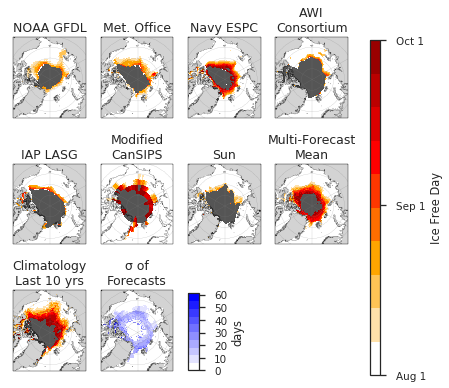

In [41]:
# New Plot
if cmonth=='July':
    NPLOTS = 11
elif cmonth=='June':
    Nplots = 12
else: 
    NPLOTS = 11
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=3, Nplots=NPLOTS, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_IFD_All.model.values):
#for (i, cmod) in enumerate(['fgoalssipn']):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    cper_mask = ds_IFD_All.sel(model=cmod)

#    print(cper_mask)
    p = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)

    # Plot perenial ice as black
    #cper_mask = ds_IFD_All.sel(model=cmod)
    pb = cper_mask.where(cper_mask==275).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

    # Add init date
#    axes[i].annotate(pd.to_datetime(ds_IFD_All.sel(model=cmod).init_date.values).strftime('%m/%d'), xy=(.6, -.15), xycoords='axes fraction', )

# MME Mean
i = i + 1

cper_mask = ds_MME_avg

pmme = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

# Plot perenial ice as black
pb = cper_mask.where(cper_mask>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_b,
                      vmin=0, vmax=1)    


axes[i].set_title('Multi-Forecast\nMean')


PlotObs = True
if PlotObs:       
    print('Climo 10 yr')
    # Climo10yrs
    i = i + 1

    pmme = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False, 
                                      cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

    # Plot perenial ice as black
    pb = climo.where(climo>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    


    axes[i].set_title('Climatology\nLast 10 yrs')
    

# MME Standard deviation
i = i + 1

print('MME sigma')

fld = ds_MME_std
landmask = fld.notnull()
fld = fld.where(cper_mask>c_vmin,other=0)
fld = fld.where(landmask)

pstd = fld.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=ds_MME_std.max().values)
axes[i].set_title('σ of\nForecasts')



# Make pretty
f.subplots_adjust(bottom=0.05)

cbar1vertical = True
if cbar1vertical:
#    cbar_ax = f.add_axes([0.95, 0.36, .05, 0.5]) #  [left, bottom, width, height]   span just top rows
    cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
else:
    cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
#cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w   FAR RIGHT
#cbar_ax_2 = f.add_axes([0.75, 0.1, .025, .28]) #  [left, bottom, width, height] w
#cbar_ax_2 = f.add_axes([0.35, 0.07, .025, .20]) #  [left, bottom, width, height] w

#cbar_ax_2 = f.add_axes([0.76, 0.07, .025, .20]) #  [left, bottom, width, height] w
#cbar_ax_2 = f.add_axes([0.33, 0.08, .025, .18]) #  [left, bottom, width, height] w
cbar_ax_2 = f.add_axes([0.53, 0.08, .025, .18]) #  [left, bottom, width, height] w


cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std_lowRes.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
diehere

## Hudson Bay Region

In [ ]:
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))
print(ds_region)
print(ds_region.region_names)

reg2plot = (2,3,4,6,7,8,9,10,11,12,13,15)
# Okhotsk, Bering, Hudson, Baffin+E. Grn., Barents+Kara, Laptev+E. Sib., Chuk+Beauf, Central

reg2plot = (2,3,4,(6,7),(8,9),(10,11),(12,13),15)

cR=2  # Hudson Bay
creg = 2

crExt = ds_region.where(ds_region.mask.isin(reg2plot[cR]), drop=True)[['xm','ym']]
crExt = [crExt.xm.min().values, crExt.xm.max().values, 
     crExt.ym.min().values, crExt.ym.max().values]
#crExt[2]=np.max([crExt[2],-3700000])


In [ ]:
c_vmax=220
c_vmin=152

In [ ]:
print(ds_IFD_All.model.values)  # get rid of models that have no Hudson Bay  
ds_IFD_Most=ds_IFD_All
ds_IFD_Most=ds_IFD_Most.where(ds_IFD_Most.model!='awispin',drop=True)
ds_IFD_Most.model.values

In [ ]:
ds_MME_avg = ds_IFD_Most.mean(dim='model') #.where((ds_IFD_All>1) & (ds_IFD_All<275))
ds_MME_std = ds_IFD_Most.std(dim='model')

In [ ]:
cvar = 'sic'
PlotObs=False
metric='IFD'

# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1
    elif metric=='IFD':
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=8)
#         cmap_c.set_bad(color = 'lightgrey')
                
        #cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        cmap_c.set_bad(color = 'lightgrey')

        cmap_std = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
        cmap_std.set_bad(color = 'lightgrey')
        
        cmap_b =  matplotlib.colors.ListedColormap(sns.color_palette("binary", 2))
        cmap_b.set_bad(color = 'None')
        
        cmap_obs =  matplotlib.colors.ListedColormap(sns.color_palette("Greys", 2))
        cmap_obs.set_bad(color = 'None')
        
        c_label = 'Ice Free Day'


elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

        
# New Plot
if cmonth=='July':
    NPLOTS = 9
else: 
    NPLOTS = 10

# New Plot
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=3, Nplots=NPLOTS, extent=crExt)

for (i, cmod) in enumerate(ds_IFD_Most.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    cper_mask = ds_IFD_Most.sel(model=cmod).isel(init_time=0)

#    print(cper_mask)
    p = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)

    pb = cper_mask.where(cper_mask==275).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

i = i + 1

cper_mask = ds_MME_avg.isel(init_time=0)

pmme = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

# Plot perenial ice as black
pb = cper_mask.where(cper_mask>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_b,
                      vmin=0, vmax=1)    


axes[i].set_title('Multi-Forecast\nMean')

    
# Climo10yrs
i = i + 1

pmme = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

# Plot perenial ice as black
pb = climo.where(climo>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_b,
                      vmin=0, vmax=1)    


axes[i].set_title('Climatology\nLast 10 yrs')
    
# MME Standard deviation
i = i + 1

pstd = ds_MME_std.isel(init_time=0).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=0.67*ds_MME_std.max().values)
axes[i].set_title('σ')



# Make pretty
f.subplots_adjust(bottom=0.05)

cbar1vertical = True
if cbar1vertical:
    cbar_ax = f.add_axes([0.95, 0.36, .05, 0.5]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
else:
    cbar_ax = f.add_axes([0.55, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
#cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w   FAR RIGHT
#cbar_ax_2 = f.add_axes([0.75, 0.1, .025, .28]) #  [left, bottom, width, height] w

cbar_ax_2 = f.add_axes([0.35, 0.07, .025, .20]) #  [left, bottom, width, height] w

cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)

# Save to file
f_out = os.path.join(fig_dir,'HudsonBay_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'HudsonBay_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std_lowRes.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)